In [25]:
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

# Extract Data

In [2]:
f = h5py.File('SG24_dataset.h5', 'r')
f.keys()

<KeysViewHDF5 ['Predictors', 'Target', 'User']>

In [3]:
tmp = f['Predictors']
predictors = np.zeros(tmp.shape)
tmp.read_direct(predictors)
predictors = predictors.T

tmp = f['Target']
target = np.zeros(tmp.shape)
tmp.read_direct(target)
target = target[0]

tmp = f['User']
user = np.zeros(tmp.shape)
tmp.read_direct(user)
user = user.T

print(predictors.shape)
print(target.shape)
print(user.shape)

(2400, 29)
(2400,)
(2400, 1)


# Simple Describe

In [5]:
pd.DataFrame(predictors).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,53.669293,-5.698329,0.203902,0.491011,-0.140472,0.164828,-0.149610,129.851667,137.503750,145.390833,...,110.054167,82.854167,103.005417,91.606667,143.834167,109.237083,120.668750,82.562500,137.099167,83.047500
std,41.520634,32.720964,22.393903,0.249192,0.281654,0.690302,0.268272,32.298842,15.895186,31.776834,...,46.031646,20.323427,45.260604,22.685341,53.253552,17.291823,29.802893,48.056139,21.926745,30.394479
min,0.000000,-81.559349,-68.739662,0.000000,-0.855817,-1.000000,-0.789427,1.000000,44.000000,36.000000,...,0.000000,1.000000,1.000000,25.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,-26.450032,-15.801244,0.314152,-0.387735,-0.846747,-0.360048,122.000000,128.000000,121.750000,...,63.000000,71.000000,79.000000,75.000000,92.000000,105.000000,104.000000,49.000000,131.000000,64.000000
50%,70.621365,0.000000,0.000000,0.555695,0.000000,0.471377,-0.062433,128.000000,135.000000,152.000000,...,132.000000,81.000000,114.000000,92.000000,159.000000,106.000000,126.000000,86.000000,141.000000,78.000000
75%,84.528341,0.000000,17.166466,0.691598,0.000000,0.629917,0.000000,134.000000,143.000000,170.000000,...,151.000000,93.000000,134.000000,111.000000,192.000000,107.000000,142.000000,116.000000,149.000000,101.000000
max,127.721718,78.185921,59.903419,0.955188,0.727471,1.000000,0.782390,238.000000,206.000000,207.000000,...,179.000000,170.000000,218.000000,229.000000,248.000000,255.000000,189.000000,216.000000,192.000000,193.000000


In [24]:
Counter(list(target))

Counter({1.0: 100,
         2.0: 100,
         3.0: 100,
         4.0: 100,
         5.0: 100,
         6.0: 100,
         7.0: 100,
         8.0: 100,
         9.0: 100,
         10.0: 100,
         11.0: 100,
         12.0: 100,
         13.0: 100,
         14.0: 100,
         15.0: 100,
         16.0: 100,
         17.0: 100,
         18.0: 100,
         19.0: 100,
         20.0: 100,
         21.0: 100,
         22.0: 100,
         23.0: 100,
         24.0: 100})

In [25]:
Counter(list(user.T[0]))

Counter({1.0: 600,
         2.0: 600,
         3.0: 360,
         4.0: 240,
         5.0: 240,
         6.0: 120,
         7.0: 120,
         8.0: 120})

# Analyse exploratoire

histo nombre d'exemple par classe<br/>
histo nombre d'exemple par user<br/>
Pour chaque user son nombre d'exemple par classe (avec decoupage des bars par user)<br/>
Pour chaque classe nb exemple par user (avec decoupage des bars par target<br/>
Mix des 2 du dessus (histo 2D)

In [10]:
user_target_df = pd.DataFrame({'user':user.T[0], 'target':target})

In [56]:
user_target_df.sample(10)

,user,target
2115,6.0,23.0
1397,3.0,17.0
169,1.0,9.0
1845,5.0,13.0
820,2.0,15.0
400,1.0,21.0
1784,4.0,23.0
667,2.0,5.0
777,2.0,12.0
529,1.0,23.0


### Nombre d'exemple par utilisateurs

In [32]:
target_by_user = user_target_df.groupby('user').sum()

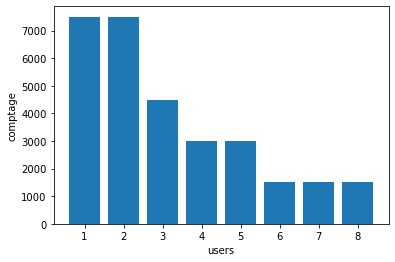

In [116]:
plt.bar(target_by_user.index, target_by_user['target'])
plt.ylabel('comptage')
plt.xlabel('users')

plt.show()

### Nombre d'exemple par utilisateurs avec la répartition des classes par user

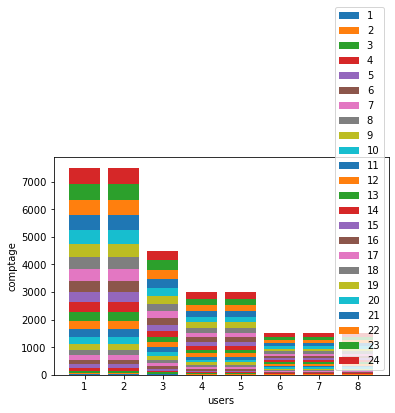

In [117]:
users = [int(u) for u in np.unique(user)]
targets = [int(t) for t in np.unique(target)]

y = []
for t in targets:
    y.append(user_target_df[user_target_df['target']==t].groupby('user').sum()['target'])
    

cum_sum = np.zeros(len(users))

bars = []
for t in targets:
    i=int(t)-1
    bars.append(plt.bar(users, y[i], bottom=cum_sum))
    cum_sum += y[i]
_ = plt.xticks(users, users)

plt.ylabel('comptage')
plt.xlabel('users')

plt.legend(bars, targets)

plt.show()

### Nombre d'exemple par target

In [37]:
user_by_target = user_target_df.groupby('target').sum()

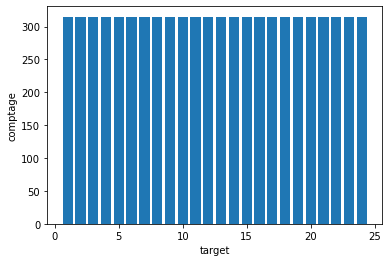

In [114]:
plt.bar(user_by_target.index, user_by_target['user'])
plt.ylabel('comptage')
plt.xlabel('target')

plt.show()

### Nombre d'exemple par target avec la répartition par user

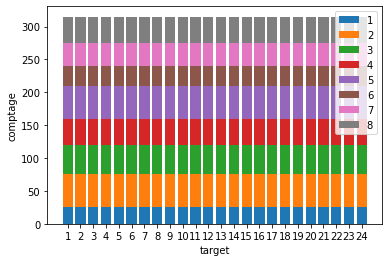

In [118]:
users = [int(u) for u in np.unique(user)]
targets = [int(t) for t in np.unique(target)]


y = []
for u in users:
    y.append(user_target_df[user_target_df['user']==u].groupby('target').sum()['user'])


cum_sum = np.zeros(len(targets))

bars = []
for u in users:
    i=int(u)-1
    bars.append(plt.bar(targets, y[i], bottom=cum_sum))
    cum_sum += y[i]
_ = plt.xticks(targets, targets)

plt.ylabel('comptage')
plt.xlabel('target')

plt.legend(bars, users)

plt.show()

# Choix des modèles et des hyper paramètres à tester

In [6]:
# List of models with hyper parameter to test
models = []

# Perceptron
percep = Perceptron()
percep_params = {'alpha' : [0.001, 0.0001]}
models.append((percep, percep_params))

# Knn
knn = KNeighborsClassifier()
knn_params = {'n_neighbors':[3, 5]}
models.append((knn, knn_params))

# Decoupage en folds

In [7]:
#kfold = KFold(n_splits=5, shuffle=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True) #Choose statified Kfold

# Application des gridSearchs et Récupérations du meilleur modèle

In [8]:
bestModel = None
bestScore = -np.inf

for model, params in models:
    currentBest = GridSearchCV(model, params, cv=kfold)
    currentBest.fit(predictors, target)
    
    if(currentBest.best_score_>bestScore):
        bestScore = currentBest.best_score_
        bestModel = currentBest.best_estimator_

# Utilisation du meilleur estimator

In [11]:
bestModel.fit(predictors, target)# Train the best model & hyper parameters with all available data (TO CONFIRM)

KNeighborsClassifier(n_neighbors=3)

In [12]:
bestModel.predict(predictors) #Test sur les données d'apprentissage

array([ 1.,  1.,  1., ...,  5., 24.,  7.])